In [51]:
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np

import pandas as pd

In [19]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20191103.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [20]:
print(df_master.columns)

Index(['PropSFHA', 'PropDG', 'AveLS', 'MaxDepth', 'HurTrack', 'PeakGust',
       'MaxSusta', 'StrVI', 'SeVI', 'Str+SeVI', 'SoVI', 'AveDepth', 'O_Ind',
       'R_Ind', 'PropSComm', 'R_I_No0', 'R_I_NoO', 'R_I_No0_NoO', 'cat_3q',
       'cat_4q', 'Count', 'R_DES', 'R_AFF'],
      dtype='object')


In [21]:
def features(df_master, feature_list):
    choices = feature_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [22]:
# EXAMPLE:
feature_list = ['PropSFHA', 'PropDG', 'AveLS', 'HurTrack',
                'PeakGust', 'StrVI', 'SeVI', 'AveDepth', 'MaxDepth', 'PropSComm']

df = features(df_master, feature_list)

Must standardize features bebfore KMeans clustering \
subtract mean and divide by standard deviation for each column


In [23]:
X = StandardScaler().fit_transform(df)

In [32]:
#manual test of standard scaler
whoa = (df-df.mean())/df.std()

In [28]:
test = pd.DataFrame(X)

The elbow method is a useful graphical tool to estimate the optimal number of clusters k for a given task. Intuitively, we can say that, if k increases, the within-cluster SSE (“distortion”) will decrease. This is because the samples will be closer to the centroids they are assigned to.

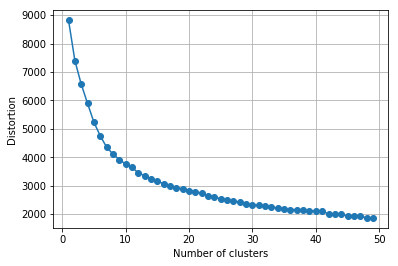

In [64]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 50):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.grid(True)
plt.ylabel('Distortion')
plt.show()

In [56]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

In [57]:
cluster = km.predict(X)

In [58]:
df['cluster'] = cluster

In [59]:
df.cluster = pd.Categorical(df.cluster)

In [60]:
df.columns

Index(['PropSFHA', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust', 'StrVI', 'SeVI',
       'AveDepth', 'MaxDepth', 'PropSComm', 'cluster'],
      dtype='object')

### Parallel Coordinates Plot
Parellel coordinates is a method for exploring the spread of multidimensional data on a categorical response, and taking a glance at whether there is any trends to the features.

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.
  """


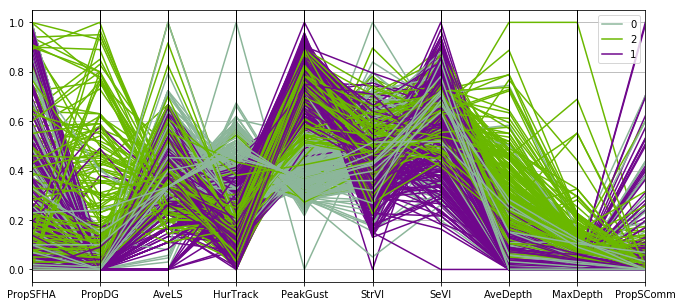

In [61]:
plt.figure(figsize=(11,5))

pd.tools.plotting.parallel_coordinates(
    df[['cluster','PropSFHA', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust', 'StrVI', 'SeVI',
       'AveDepth', 'MaxDepth', 'PropSComm']], 'cluster')


plt.show()

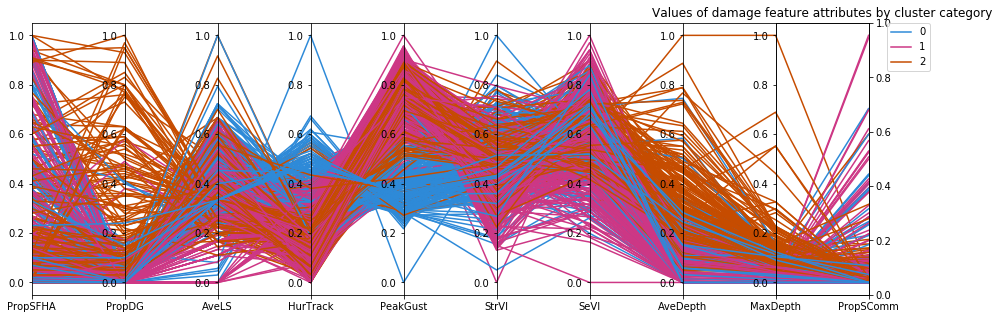

In [62]:
cols = ['PropSFHA', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust', 'StrVI', 'SeVI',
       'AveDepth', 'MaxDepth', 'PropSComm']
x = [i for i, _ in enumerate(cols)]
colours = ['#2e8ad8', '#cd3785', '#c64c00', '#889a00']

# create dict of categories: colours
colours = {df['cluster'].cat.categories[i]: colours[i] for i, _ in enumerate(df['cluster'].cat.categories)}

# Create (X-1) sublots along x axis
fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

# Get min, max and range for each column
# Normalize the data for each column
min_max_range = {}
for col in cols:
    min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
    df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

# Plot each row
for i, ax in enumerate(axes):
    for idx in df.index:
        mpg_category = df.loc[idx, 'cluster']
        ax.plot(x, df.loc[idx, cols], colours[mpg_category])
    ax.set_xlim([x[i], x[i+1]])
    
# Set the tick positions and labels on y axis for each plot
# Tick positions based on normalised data
# Tick labels are based on original data
def set_ticks_for_axis(dim, ax, ticks):
    min_val, max_val, val_range = min_max_range[cols[dim]]
    step = val_range / float(ticks-1)
    tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
    norm_min = df[cols[dim]].min()
    norm_range = np.ptp(df[cols[dim]])
    norm_step = norm_range / float(ticks-1)
    ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
    ax.yaxis.set_ticks(ticks)
    ax.set_yticklabels(tick_labels)

for dim, ax in enumerate(axes):
    ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[dim]])
    

# Move the final axis' ticks to the right-hand side
ax = plt.twinx(axes[-1])
dim = len(axes)
ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
set_ticks_for_axis(dim, ax, ticks=6)
ax.set_xticklabels([cols[-2], cols[-1]])


# Remove space between subplots
plt.subplots_adjust(wspace=0)

# Add legend to plot
plt.legend(
    [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df['cluster'].cat.categories],
    df['cluster'].cat.categories,
    bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

plt.title("Values of damage feature attributes by cluster category")

plt.show()